In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from io import StringIO

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

In [ ]:

def get_worldbank_data(country_code, indicator, start=2013, end=2023):
    """Загружает данные World Bank API по стране и индикатору"""
    url = f"https://api.worldbank.org/v2/country/{country_code}/indicator/{indicator}?format=json&date={start}:{end}&per_page=200"
    r = requests.get(url)
    data = r.json()
    if not isinstance(data, list) or len(data) < 2:
        return pd.DataFrame()
    records = data[1]
    df = pd.DataFrame([{
        "Country": rec["country"]["value"].lower(),
        "Year": int(rec["date"]),
        "Value": rec["value"],
        "Indicator": indicator
    } for rec in records if rec["value"] is not None])
    return df

countries = {
    "POL": "Poland",
    "TUR": "Turkey",
    "IND": "India",
    "BRA": "Brazil",
    "ZAF": "South Africa"
}

indicators = {
    "NY.GDP.MKTP.CD": "GDP (current US$)"
}

all_data = []
for code, name in countries.items():
    for ind_code, ind_name in indicators.items():
        df = get_worldbank_data(code, ind_code)
        df["Country_Name"] = name
        all_data.append(df)

api_data = pd.concat(all_data, ignore_index=True)
print("API данные успешно загружены! Строк:", len(api_data))
print(api_data.head())

✅ API данные успешно загружены! Строк: 55
  Country  Year         Value       Indicator Country_Name
0  poland  2023  8.124511e+11  NY.GDP.MKTP.CD       Poland
1  poland  2022  6.956075e+11  NY.GDP.MKTP.CD       Poland
2  poland  2021  6.891702e+11  NY.GDP.MKTP.CD       Poland
3  poland  2020  6.059142e+11  NY.GDP.MKTP.CD       Poland
4  poland  2019  6.026838e+11  NY.GDP.MKTP.CD       Poland


In [ ]:
url = "https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_per_capita"
headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

tables = soup.find_all("table", {"class": "wikitable"})


def likely_country_table(df):
    for col in df.columns:
        sample = df[col].astype(str).head(10)
        if sample.str.contains(r"[A-Za-z]").any() and not sample.str.isnumeric().all():
            return True
    return False


target_df = None
for i, table in enumerate(tables):
    try:
        temp_df = pd.read_html(StringIO(str(table)))[0]
        if likely_country_table(temp_df):
            target_df = temp_df
            print(f"Найдена таблица с индексом {i}")
            break
    except Exception:
        continue

if target_df is None:
    raise Exception("Не удалось найти таблицу со странами!")


df = target_df.copy()


for col in df.columns:
    if df[col].astype(str).str.contains(r"[A-Za-z]").any():
        country_col = col
        break


gdp_col = df.columns[list(df.columns).index(country_col) + 1]


df = df.rename(columns={
    country_col: "Country",
    gdp_col: "GDP_per_capita_USD"
})

if "World Bank (2022–24)[6]" in df.columns:
    df["GDP_per_capita_USD"] = df["GDP_per_capita_USD"].fillna(df["World Bank (2022–24)[6]"])

df = df.dropna(subset=["Country", "GDP_per_capita_USD"])


df["GDP_per_capita_USD"] = (
    df["GDP_per_capita_USD"]
    .astype(str)
    .str.replace(",", "")
    .str.extract(r"(\d+\.?\d*)")[0]
    .astype(float)
)


df["Country"] = df["Country"].astype(str).str.strip().str.lower()


name_map = {
    "türkiye": "turkey",
    "brasil": "brazil",
}
df["Country"] = df["Country"].replace(name_map)

selected_countries = ["brazil", "india", "poland", "south africa", "turkey"]
df = df[df["Country"].isin(selected_countries)]


print("Финальные данные Wikipedia (только нужные страны):")
print(df)


df.to_csv("wiki_data.csv", index=False)
print("Wikipedia данные сохранены (wiki_data.csv)")


✅ Найдена таблица с индексом 0
📘 Финальные данные Wikipedia (только нужные страны):
          Country  GDP_per_capita_USD World Bank (2022–24)[6]  \
63         poland             28485.0                   25023   
85         turkey             18198.0                   15473   
108        brazil              9964.0                   10280   
135  south africa              6397.0                    6253   
166         india              2878.0                    2697   

    United Nations (2023)[7]  
63                     20876  
85                     12814  
108                    10378  
135                     5976  
166                     2487  
✅ Wikipedia данные сохранены (wiki_data.csv)


In [ ]:
latest_year = api_data["Year"].max()
api_latest = api_data[
    (api_data["Year"] == latest_year) &
    (api_data["Indicator"] == "NY.GDP.MKTP.CD")
]

api_latest.loc[:, "Country"] = api_latest["Country"].replace({"turkiye": "turkey"}).str.lower().str.strip()

merged = pd.merge(api_latest, df, on="Country", how="inner")

print("Данные объединены:", merged.shape)
print(merged[["Country", "Value", "GDP_per_capita_USD"]])

✅ Данные объединены: (5, 8)
        Country         Value  GDP_per_capita_USD
0        poland  8.124511e+11             28485.0
1        turkey  1.118253e+12             18198.0
2         india  3.638489e+12              2878.0
3        brazil  2.191132e+12              9964.0
4  south africa  3.806993e+11              6397.0



📊 Описательная статистика:
              Value  GDP_per_capita_USD
count  5.000000e+00            5.000000
mean   1.628205e+12        13184.400000
std    1.307661e+12        10270.177715
min    3.806993e+11         2878.000000
25%    8.124511e+11         6397.000000
50%    1.118253e+12         9964.000000
75%    2.191132e+12        18198.000000
max    3.638489e+12        28485.000000

📈 Корреляция между GDP и GDP_per_capita:
                       Value  GDP_per_capita_USD
Value               1.000000           -0.541749
GDP_per_capita_USD -0.541749            1.000000


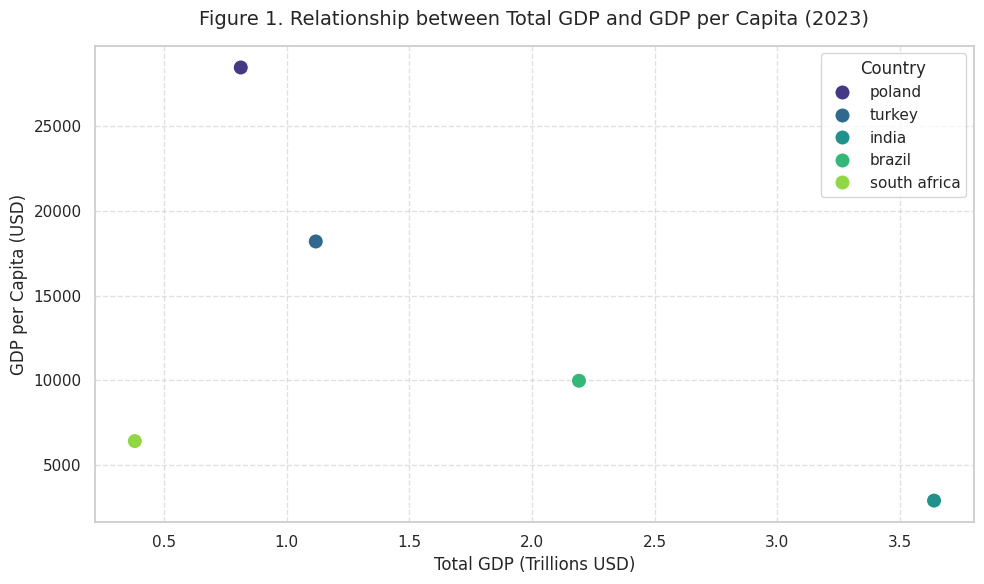

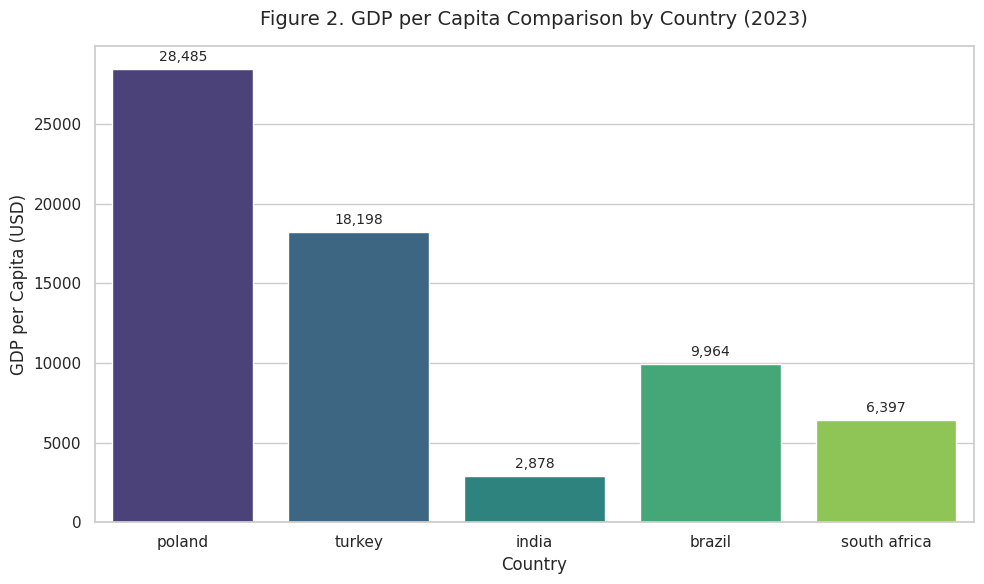

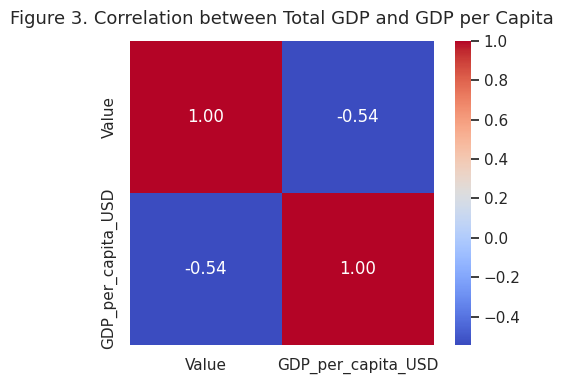

In [ ]:
print("\n📊 Описательная статистика:")
print(merged[["Value", "GDP_per_capita_USD"]].describe())

print("\n📈 Корреляция между GDP и GDP_per_capita:")
print(merged[["Value", "GDP_per_capita_USD"]].corr())

plt.figure(figsize=(10,6))
sns.scatterplot(
    x="Value",
    y="GDP_per_capita_USD",
    hue="Country",
    data=merged,
    s=120,
    palette="viridis",
)

plt.title("Figure 1. Relationship between Total GDP and GDP per Capita (2023)", fontsize=14, pad=15)
plt.xlabel("Total GDP (Trillions USD)", fontsize=12)
plt.ylabel("GDP per Capita (USD)", fontsize=12)


ax = plt.gca()
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e12:.1f}"))

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Country")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
sns.barplot(
    x="Country",
    y="GDP_per_capita_USD",
    hue="Country",
    data=merged,
    palette="viridis",
    legend=False
)

plt.title("Figure 2. GDP per Capita Comparison by Country (2023)", fontsize=14, pad=15)
plt.xlabel("Country", fontsize=12)
plt.ylabel("GDP per Capita (USD)", fontsize=12)


for i, row in enumerate(merged.itertuples()):
    plt.text(i, row.GDP_per_capita_USD + 500, f"{int(row.GDP_per_capita_USD):,}",
             ha="center", fontsize=10)

plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
corr_matrix = merged[["Value", "GDP_per_capita_USD"]].corr()
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    square=True,
    cbar=True
)
plt.title("Figure 3. Correlation between Total GDP and GDP per Capita", fontsize=13, pad=12)
plt.tight_layout()
plt.show()
